In [1]:
import networkx as nx
import torch

from src.archetypes import SBM, BiAA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

In [2]:
df = pd.read_csv("datasets/github/data.txt", sep=":", header=None)
# df = pd.read_csv("~/Downloads/meddra.tsv", sep="\t", header=None)
df

,0,1
0,1,1
1,2,2
2,3,3
3,4,4
4,5,5
...,...,...
440232,301,6979
440233,3341,330
440234,2196,103699
440235,1171,3


In [3]:
B = nx.Graph()
B.add_nodes_from(df.iloc[:, 0].unique(), bipartite=0)
B.add_nodes_from(df.iloc[:, 1].unique(), bipartite=1)

B.add_edges_from(
    [(row[0], row[1]) for idx, row in df.iterrows()])

In [4]:
from networkx.algorithms import bipartite

a = bipartite.biadjacency_matrix(B, df.iloc[:, 0].unique()).astype(np.float32).todense()
a = torch.tensor(a)
a.shape

/var/folders/tj/q2qz82qj46qf7mwzd_jqkxnc0000gn/T/ipykernel_17277/2847010717.py:3: FutureWarning: biadjacency_matrix will return a scipy.sparse array instead of a matrix in NetworkX 3.0
  a = bipartite.biadjacency_matrix(B, df.iloc[:, 0].unique()).astype(np.float32).todense()


torch.Size([56519, 65190])

In [ ]:
cmap = sns.color_palette("Greys", as_cmap=True)
sns.heatmap(a, cmap=cmap, cbar=False)
plt.show()

## BiAA method

In [5]:
def order_a(a, model):
    ind_0 = [i0 for i0, _ in sorted([(i, k.item()) for i, k in enumerate(model.A.argmax(dim=1))], key=lambda j: j[1])]
    ind_1 = [i0 for i0, _ in sorted([(i, k.item()) for i, k in enumerate(model.D.argmax(dim=0))], key=lambda j: j[1])]
    hlines = [0] + [i for i in np.array(model.A.argmax(dim=1).bincount()).cumsum()]
    vlines = [0] + [i for i in np.array(model.D.argmax(dim=0).bincount()).cumsum()]
    ordered_a = a[ind_0, :][:, ind_1]
    return ordered_a, hlines, vlines

In [ ]:
k = 5, 5
model_biaa = None
for _ in range(3):
    model_i = BiAA(k, a, likelihood="bernoulli", assignment="soft")
    model_i.fit(200, learning_rate=0.1, print_loss=True)
    if not model_biaa or  model_i.losses[-1] < model_biaa.losses[-1]:
        model_biaa = model_i
    plt.plot(model_i.losses)
    plt.show()

In [55]:
oa, hlines, vlines = order_a(a, model_biaa)

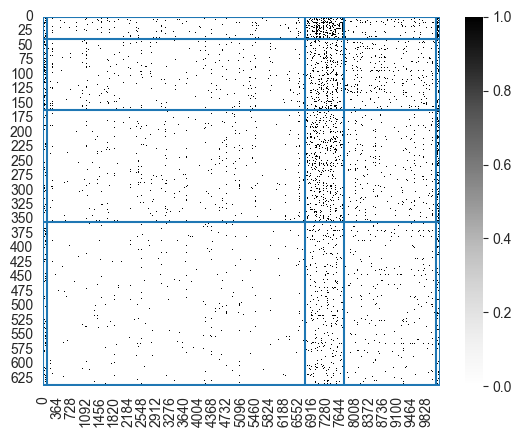

In [56]:
sns.heatmap(oa, vmin=0, vmax=1, cmap=cmap)
for hl in hlines:
    pass
    plt.axhline(hl)
for vl in vlines:
    pass
    plt.axvline(vl)
plt.show()

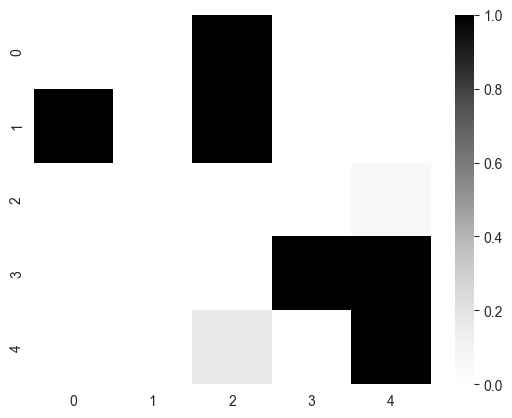

In [35]:
sns.heatmap(model_biaa.Z.detach(), vmin=0, vmax=1, cmap=cmap)
plt.show()

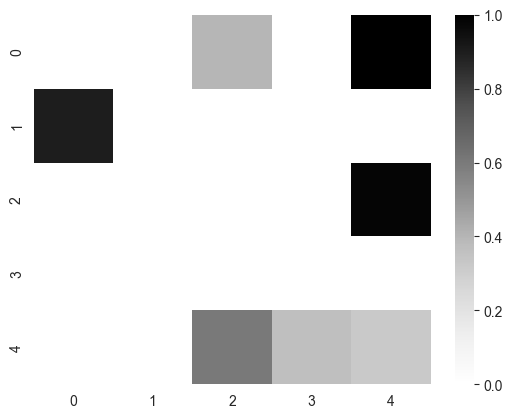

In [57]:
sns.heatmap(model_biaa.Z.detach(), vmin=0, vmax=1, cmap=cmap)
plt.show()